# TreeVAE

### Table Of Contents
1. [Data Loading](#section_1)
2. [Generations](#section_2)
3. [Reconstructions](#section_3)
4. [Tree and Representation Analysis](#section_4)
5. [CelebA Attributes](#section_5)

This is the notebook for analyzing and visualizing the trees learnt by TreeVAE. 

Trees can be learnt by running main.py and stored by setting the option save_model to True in the config file.



## <a name="section_1"></a> 1. Data Loading

Always execute this section first. This section loads the data and model and computes the NMI to ensure that the model was loaded correctly. Make sure to set the path in the second cell to the specific model that you want to analyze.

In [1]:
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from models.model import TreeVAE
import scipy
import os
import yaml
import gc
from tqdm import tqdm
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from pathlib import Path
from utils.utils import reset_random_seeds, display_image
from utils.data_utils import get_data, get_gen
from utils.training_utils import compute_leaves, predict, move_to
from train.validate_tree import compute_likelihood
from models.model_smalltree import SmallTreeVAE
from models.losses import loss_reconstruction_binary, loss_reconstruction_mse, loss_reconstruction_cov_mse_eval
from utils.model_utils import Node, construct_tree_fromnpy, return_list_tree, construct_data_tree, construct_tree_fromnpy
from utils.plotting_utils import plot_tree_graph, get_node_embeddings, draw_tree_with_scatter_plots

In [2]:
path = 'models/experiments/'
ex_path = 'mnist/20231025-175819_d6be9' # INSERT YOUR PATH HERE
checkpoint_path = path+ex_path
with open(checkpoint_path + "/config.yaml", 'r') as stream:
    configs = yaml.load(stream,Loader=yaml.Loader)
print(configs)

{'data': {'data_name': 'mnist', 'num_clusters_data': 10}, 'globals': {'config_name': 'mnist', 'eager_mode': True, 'results_dir': PosixPath('/home/mvandenhi/Documents/projects/treevae/models/experiments'), 'save_model': True, 'seed': 42, 'wandb_logging': 'disabled'}, 'parser': {}, 'run_name': 'mnist', 'training': {'activation': 'sigmoid', 'aug_decisions_weight': 1, 'augment': False, 'augmentation_method': ['simple'], 'batch_size': 256, 'compute_ll': False, 'decay_kl': 0.001, 'decay_lr': 0.1, 'decay_stepsize': 100, 'encoder': 'cnn1', 'grow': True, 'initial_depth': 1, 'inp_shape': 784, 'intermediate_fulltrain': True, 'kl_start': 0.0, 'latent_dim': [8, 8, 8, 8, 8, 8], 'lr': 0.001, 'mlp_layers': [128, 128, 128, 128, 128, 128], 'num_clusters_tree': 10, 'num_epochs': 150, 'num_epochs_finetuning': 200, 'num_epochs_intermediate_fulltrain': 80, 'num_epochs_smalltree': 150, 'prune': True, 'weight_decay': 1e-05}}


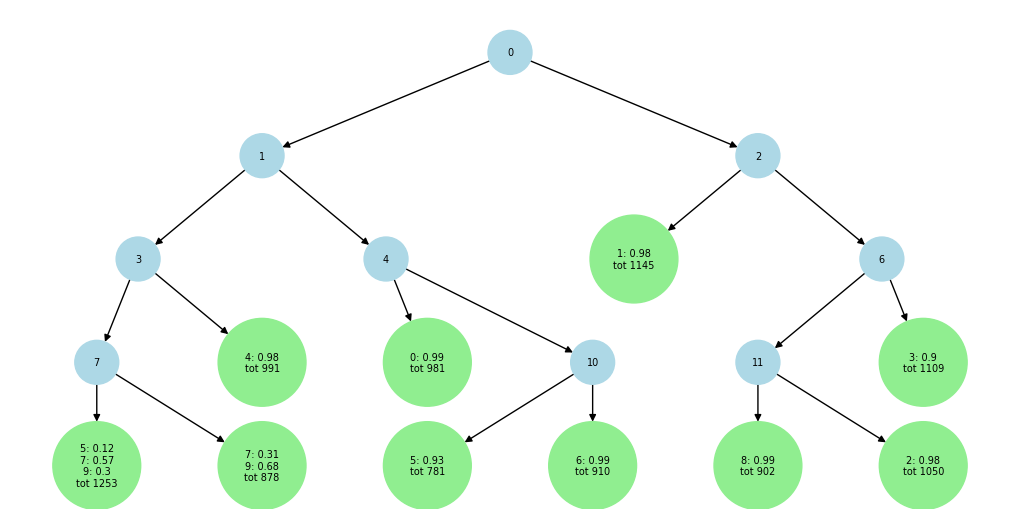

In [3]:
# Load Data
trainset, trainset_eval, testset = get_data(configs)
gen_train = get_gen(trainset, configs, validation=False, shuffle=False)
gen_train_eval = get_gen(trainset_eval, configs, validation=True, shuffle=False)
gen_test = get_gen(testset, configs, validation=True, shuffle=False)
gen_train_eval_iter = iter(gen_train_eval)
gen_test_iter = iter(gen_test)
y_train = trainset_eval.dataset.targets[trainset_eval.indices].numpy()
y_test = testset.dataset.targets[testset.indices].numpy()

# Load Model
n_d = configs['training']['num_clusters_tree']
model = TreeVAE(**configs['training'])
data_tree = np.load(checkpoint_path+'/data_tree.npy', allow_pickle=True)
model = construct_tree_fromnpy(model, data_tree, configs)
if not configs['globals']['eager_mode']:
    model = torch.compile(model)
model.load_state_dict(torch.load(checkpoint_path+'/model_weights.pt'),strict=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

plot_tree_graph(data_tree)

In [4]:
# Compute Train NMI
prob_leaves = predict(gen_train_eval, model, device,'prob_leaves')
y = np.squeeze(np.argmax(prob_leaves, axis=-1))
print('Train NMI:',normalized_mutual_info_score(y, np.squeeze(y_train)))

tot_counts = []
print("                                  Leaf", np.arange(10))
for i in np.unique(y_test):
    list_y_hat, counts = np.unique(y[np.squeeze(y_train)==i], return_counts=True)
    for j in range(n_d):
        if j not in list_y_hat:
            list_y_hat = np.insert(list_y_hat, j, j)
            counts = np.insert(counts, j, 0)
    tot_counts.append(counts)
    print(f"Class {i:<10}", list_y_hat, counts)

100%|█████████████████████████████████████████| 235/235 [00:05<00:00, 46.75it/s]

Train NMI: 0.8610907453583535
                                  Leaf [0 1 2 3 4 5 6 7 8 9]
Class 0          [0 1 2 3 4 5 6 7 8 9] [   2    1 5879    7    0    2    4   24    1    3]
Class 1          [0 1 2 3 4 5 6 7 8 9] [6550   32    1    1   15    0    0    0    3  140]
Class 2          [0 1 2 3 4 5 6 7 8 9] [  19    3    1   20   16    2    5    0    3 5889]
Class 3          [0 1 2 3 4 5 6 7 8 9] [   1    0    2 6052   13   12   14    0    9   28]
Class 4          [0 1 2 3 4 5 6 7 8 9] [   6 5803    3    0   10   11    0    3    4    2]
Class 5          [0 1 2 3 4 5 6 7 8 9] [   0    0    6   29 1047    4 4320    8    5    2]
Class 6          [0 1 2 3 4 5 6 7 8 9] [  11    7    8    2    1    0  356 5525    6    2]
Class 7          [0 1 2 3 4 5 6 7 8 9] [  64   23    3    1 4412 1717    1    0    2   42]
Class 8          [0 1 2 3 4 5 6 7 8 9] [   7    5    2  388   15    3   32    3 5387    9]
Class 9          [0 1 2 3 4 5 6 7 8 9] [  13   50    7  130 2402 3329    9    1    7    1]

In [5]:
# Compute Test NMI
prob_leaves = predict(gen_test, model, device,'prob_leaves')
y = np.squeeze(np.argmax(prob_leaves, axis=-1))
print('Test NMI:', normalized_mutual_info_score(y, np.squeeze(y_test)))

tot_counts = []
print("                                  Leaf", np.arange(10))
for i in np.unique(y_test):
    list_y_hat, counts = np.unique(y[np.squeeze(y_test)==i], return_counts=True)
    for j in range(n_d):
        if j not in list_y_hat:
            list_y_hat = np.insert(list_y_hat, j, j)
            counts = np.insert(counts, j, 0)
    tot_counts.append(counts)
    print(f"Class {i:<10}", list_y_hat, counts)

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.58it/s]

Test NMI: 0.867197223330794
                                  Leaf [0 1 2 3 4 5 6 7 8 9]
Class 0          [0 1 2 3 4 5 6 7 8 9] [  0   0 975   1   1   0   1   1   1   0]
Class 1          [0 1 2 3 4 5 6 7 8 9] [1120    2    0    2    0    0    0    0    1   10]
Class 2          [0 1 2 3 4 5 6 7 8 9] [   1    0    0    3    2    0    0    0    2 1024]
Class 3          [0 1 2 3 4 5 6 7 8 9] [   0    0    0 1001    3    1    3    0    2    0]
Class 4          [0 1 2 3 4 5 6 7 8 9] [  0 973   0   0   2   3   0   2   2   0]
Class 5          [0 1 2 3 4 5 6 7 8 9] [  0   0   1   9 150   0 730   2   0   0]
Class 6          [0 1 2 3 4 5 6 7 8 9] [  4   2   3   0   0   1  42 903   1   2]
Class 7          [0 1 2 3 4 5 6 7 8 9] [ 17   3   2   1 720 271   0   0   2  12]
Class 8          [0 1 2 3 4 5 6 7 8 9] [  1   0   0  74   3   1   0   2 891   2]
Class 9          [0 1 2 3 4 5 6 7 8 9] [  2  11   0  18 372 601   5   0   0   0]


## <a name="section_2"></a> 2. Generations

This section is concerned with unconditionally generating new samples as opposed to reconstructing existing data points.

### Clusterwise generations

Here, given one unconditional random sampling from the root, we visualize the generations for each leaf. That is, each row corresponds to one sample and each column corresponds to one leaf. Above each generation, we provide the probability of falling into the respective leaf for this sample. 

This way of visualization can provide insights on the characteristics each leaf is associated with. Observe that the generations differ across the leaves, as each leaf decodes the sample in the style of the cluster that it learnt. It is likely that cluster-differences are observed more strongly than in the reconstructions' section, as here, we have no guiding information from the bottom-up.

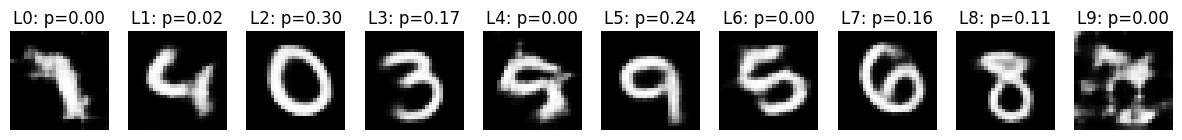

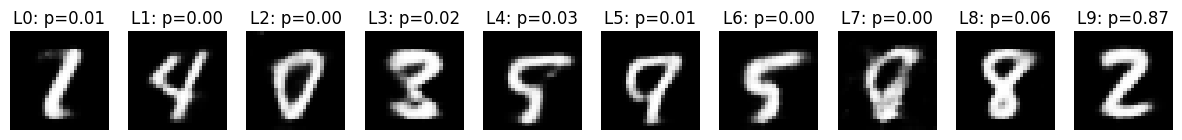

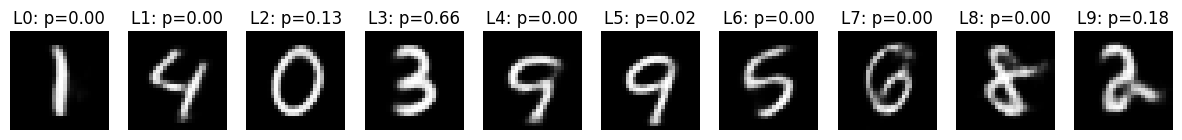

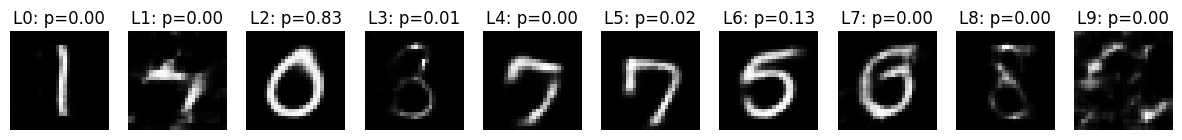

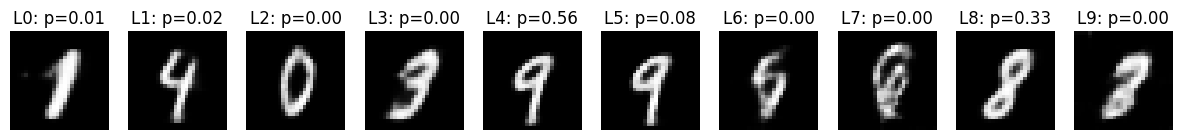

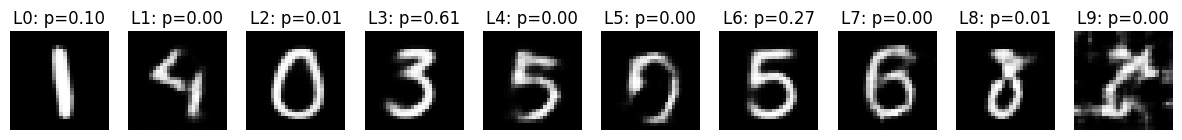

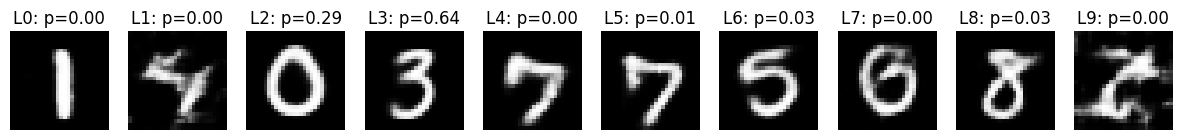

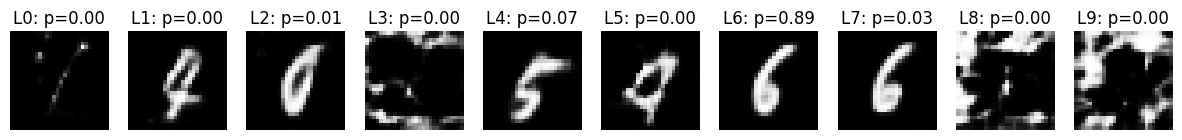

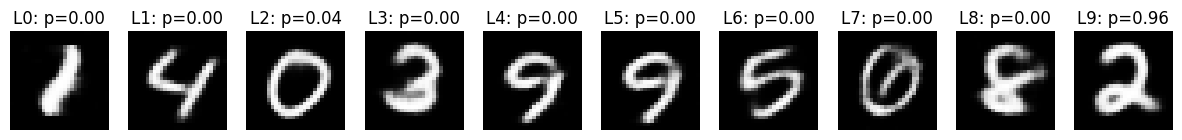

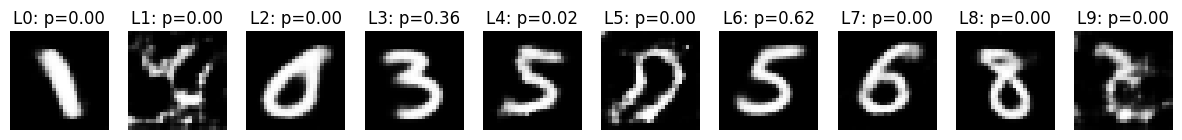

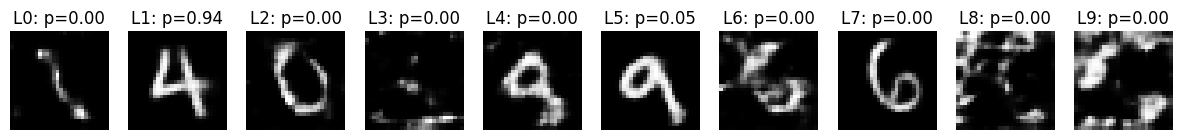

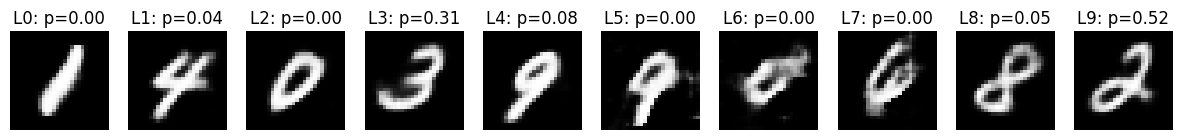

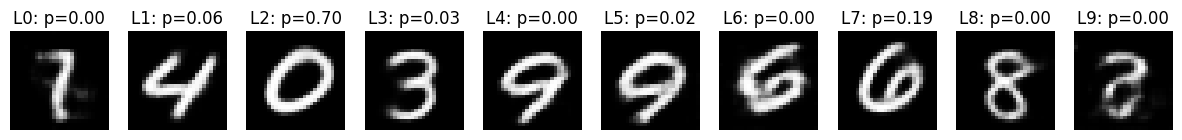

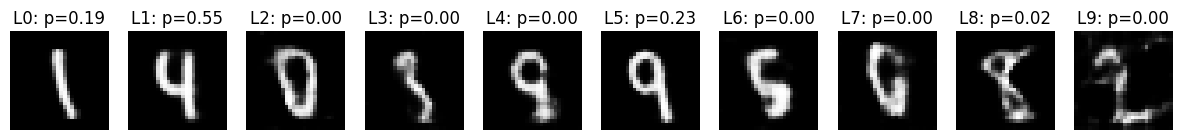

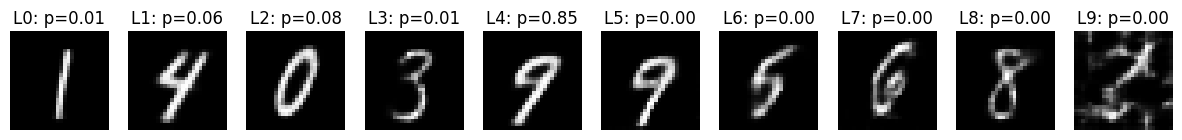

In [6]:
n_imgs = 15
with torch.no_grad():
    reconstructions, p_c_z = model.generate_images(n_imgs, device)
reconstructions = move_to(reconstructions, 'cpu')
for i in range(n_imgs):
    fig, axs = plt.subplots(1, n_d, figsize=(15, 15))
    for c in range(n_d):
        axs[c].imshow(display_image(reconstructions[c][i]), cmap=plt.get_cmap('gray'))
        axs[c].set_title(f"L{c}: " + f"p=%.2f" % torch.round(p_c_z[i][c],decimals=2))
        axs[c].axis('off')
    plt.show()

### Generate new images according to cluster assignment

In this subsection, given a leaf, we store the first 100 generations, for which this leaf is their most likely cluster assignment. This allows us to gain insights on the cluster and characteristics that each leaf learnt.

In [7]:
# Here, we store generations for each leaf simultaneously until
# every leaf has n_imgs associated generations, or we iterated through max_iter batches.
n_imgs = configs['training']['batch_size']
max_iter = 200

with torch.no_grad():
    reconstructions, p_c_z = model.generate_images(n_imgs, device)
reconstructions = move_to(reconstructions, 'cpu')
clusterwise_reconst = [torch.zeros_like(reconstructions[0][0:2]) for i in range(len(reconstructions))]
n_iter=0
while min([clusterwise_reconst[leaf_ind].shape[0] for leaf_ind in range(len(reconstructions))]) < n_imgs+2 and n_iter < max_iter:
    for i in range(n_imgs):
        leaf_ind = torch.argmax(p_c_z[i])
        if clusterwise_reconst[leaf_ind].shape[0] < n_imgs+2:
            clusterwise_reconst[leaf_ind] = torch.vstack([clusterwise_reconst[leaf_ind], reconstructions[leaf_ind][i].unsqueeze(0)])
    with torch.no_grad():
        reconstructions, p_c_z = model.generate_images(n_imgs, device)
    reconstructions = move_to(reconstructions, 'cpu')
    n_iter += 1
    if n_iter %10 == 0:
        print(n_iter)
for i in range(len(reconstructions)):
    clusterwise_reconst[i] = clusterwise_reconst[i][2:,:]

10


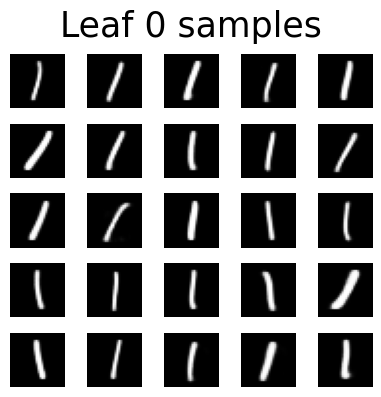

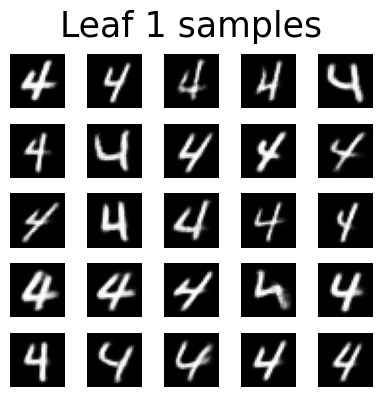

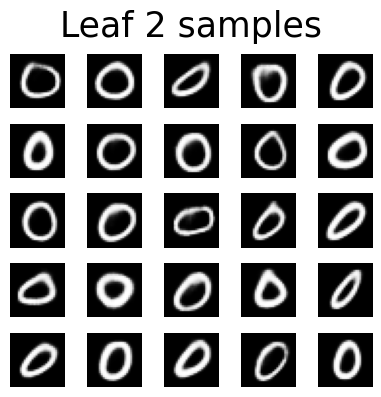

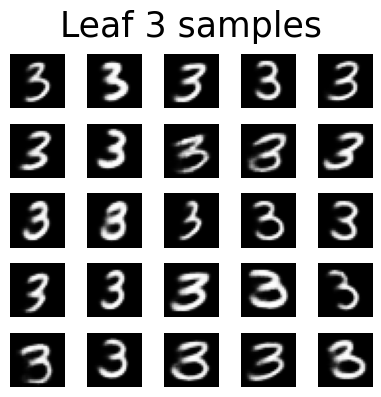

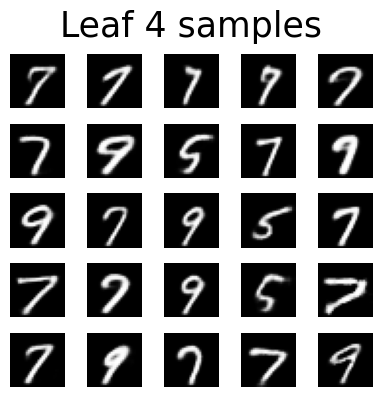

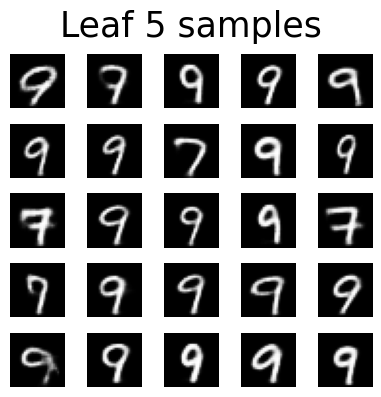

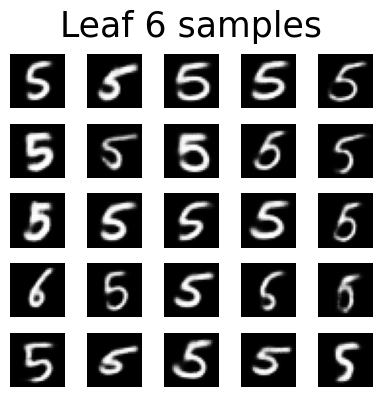

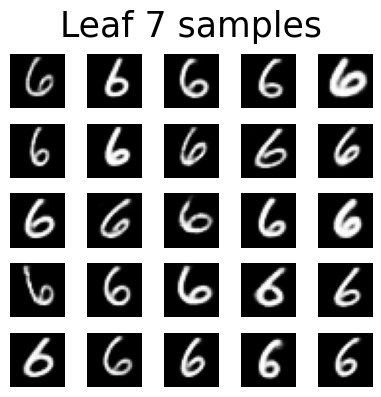

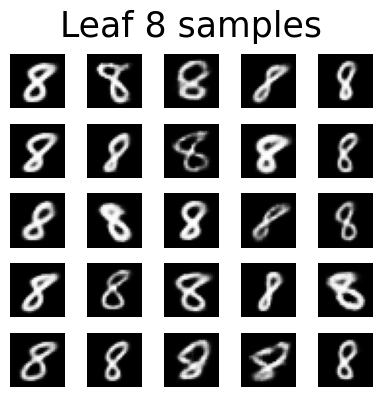

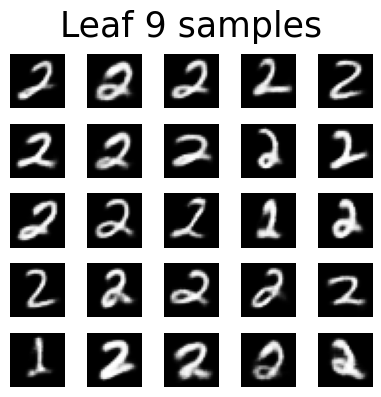

In [8]:
# For each leaf, we visualize n_grid x n_grid generations, 
# which have highest probability of being assigned to this cluster
n_leaves = len(clusterwise_reconst)
n_grid = min(5,int((clusterwise_reconst[leaf_ind].shape[0])**.5))

k=0
for l in range(n_leaves):
        fig, axs = plt.subplots(n_grid, n_grid, figsize=(4,4))
        i=0
        for a in range(n_grid):
            for b in range(n_grid):
                axs[a,b].set_axis_off()
                axs[a,b].imshow(display_image(clusterwise_reconst[k][i]), cmap=plt.get_cmap('gray'))
                i+=1
        fig.suptitle(f"Leaf {k} samples",fontsize=25)
        fig.tight_layout()
        fig.subplots_adjust(top=0.87)
        k+=1
plt.show()

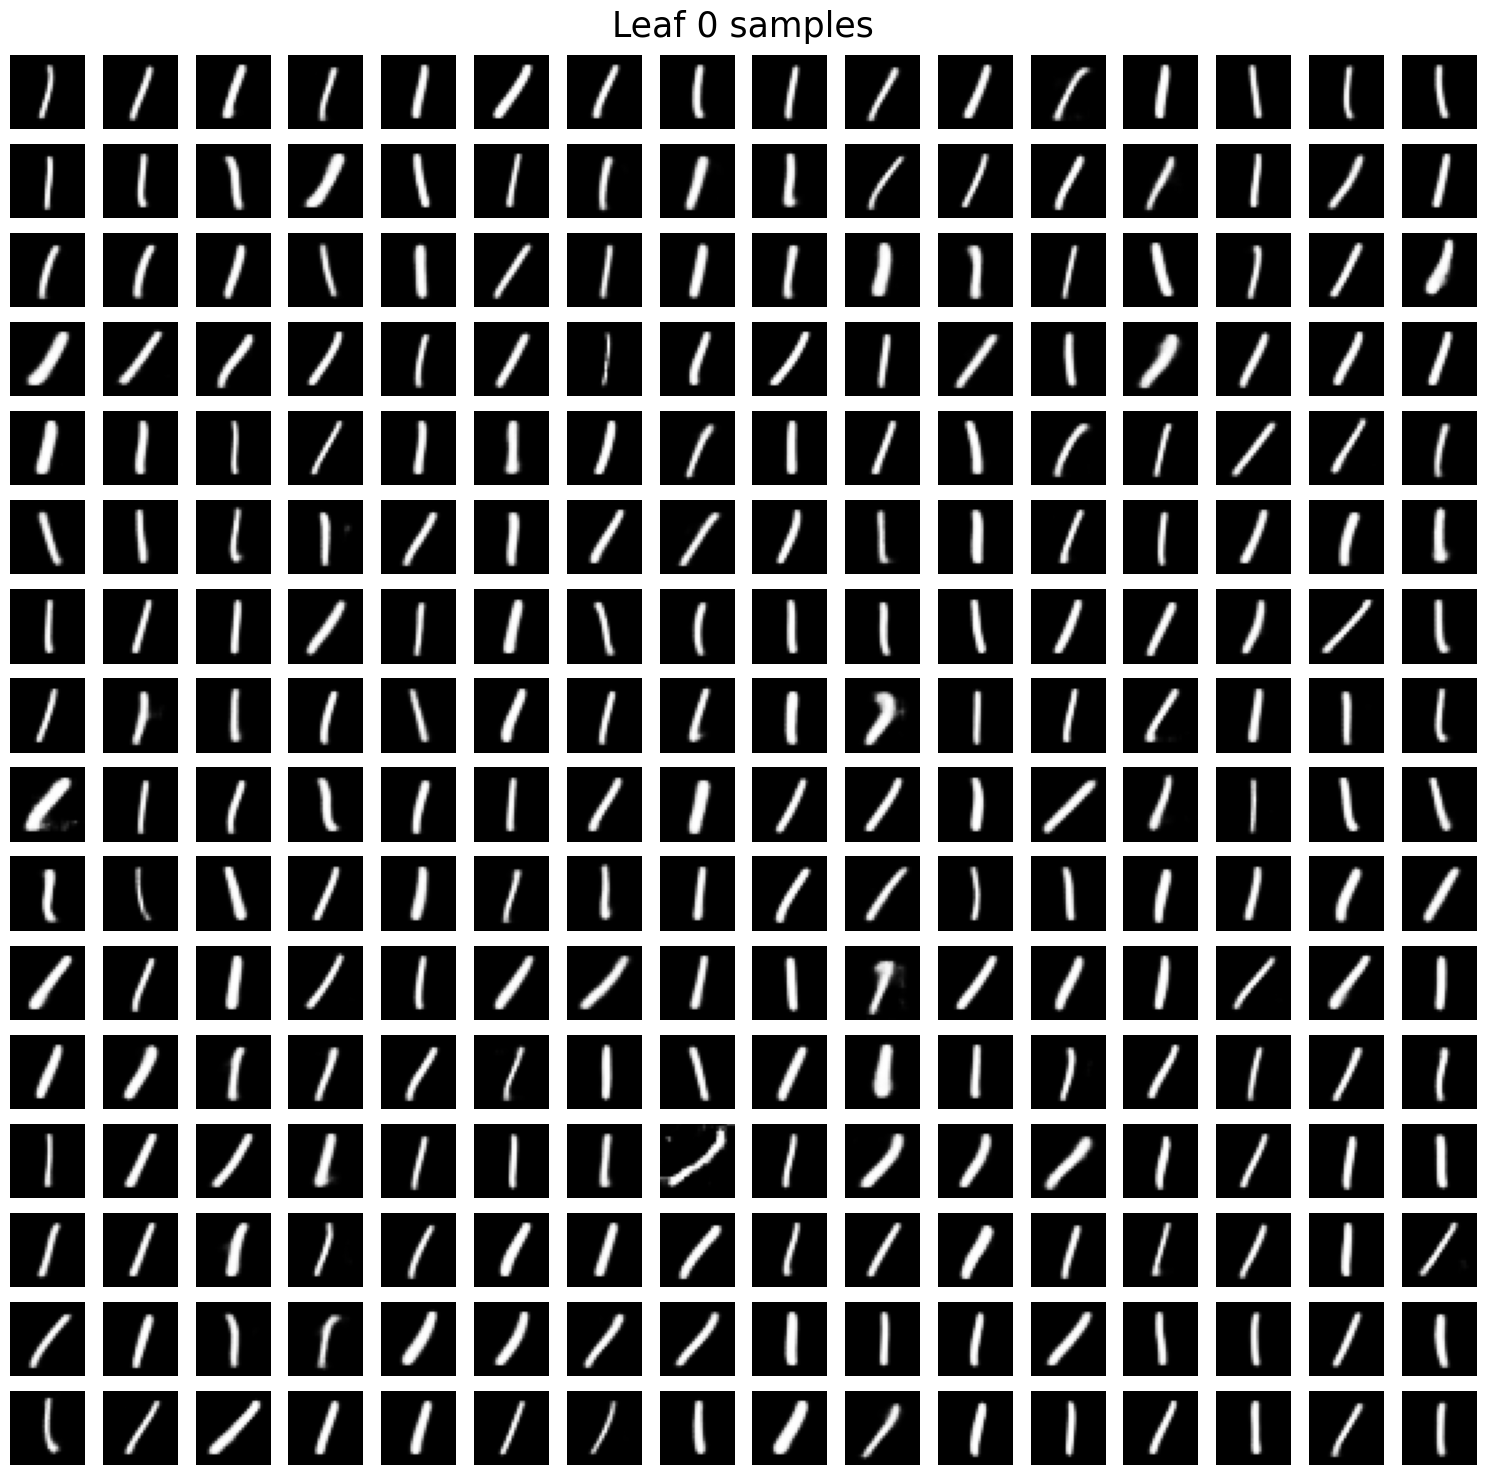

In [9]:
# For closer inspection, one can select a specific leaf by leaf_ind and investigate more generations.
leaf_ind = 0
    
n_grid = int((clusterwise_reconst[leaf_ind].shape[0])**.5)
fig, axs = plt.subplots(n_grid, n_grid, figsize=(15,15))

i=0
for a in range(n_grid):
    for b in range(n_grid):
        axs[a,b].set_axis_off()
        axs[a,b].imshow(display_image(clusterwise_reconst[leaf_ind][i]), cmap=plt.get_cmap('gray'))
        i+=1
fig.suptitle(f"Leaf {leaf_ind} samples",fontsize=25)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## <a name="section_3"></a> 3. Reconstructions

This section is concerned with computing reconstructions of input samples.

### Clusterwise reconstructions

Here, given one input image, we visualize the reconstructions for each leaf. That is, each row corresponds to one input image and each column corresponds to one leaf. Above each reconstruction, we provide the probability of falling into the respective leaf for this sample. 

This way of visualization can provide insights on the characteristics each leaf is associated with. Observe that the reconstructions differ across the leaves, as each leaf reconstructs the image in the style of the cluster that it learnt.

Class: 5


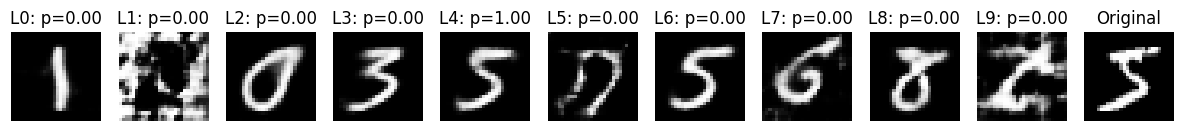

Class: 0


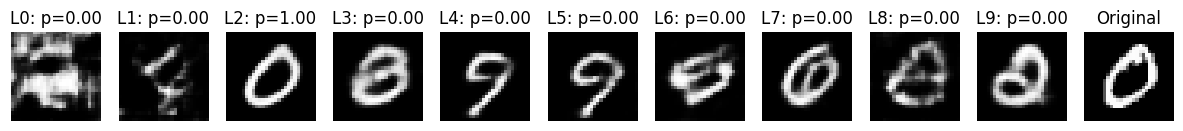

Class: 4


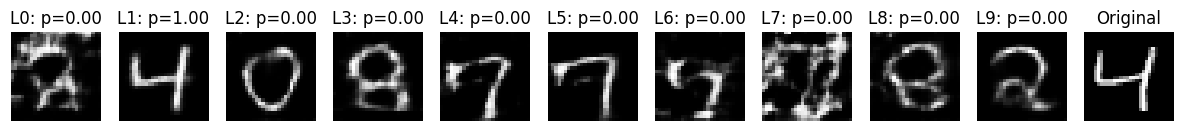

Class: 1


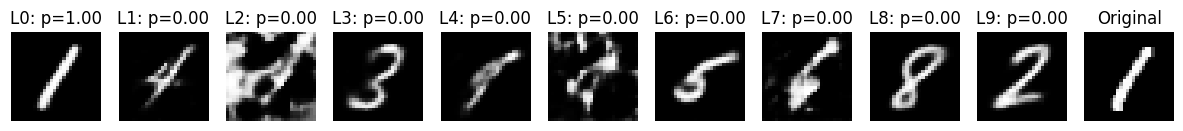

Class: 9


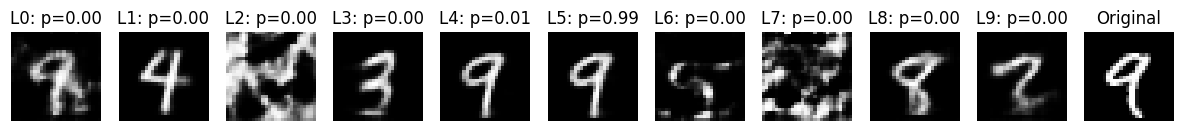

Class: 2


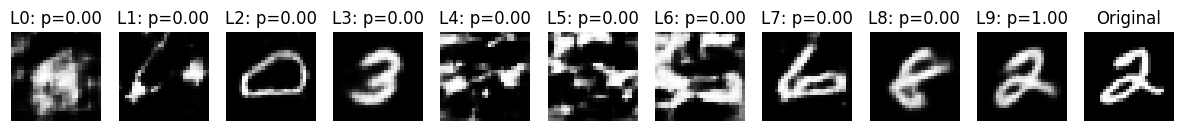

Class: 1


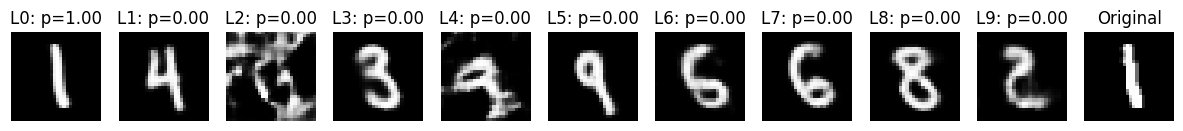

Class: 3


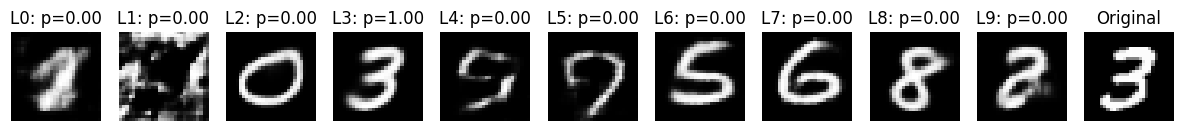

Class: 1


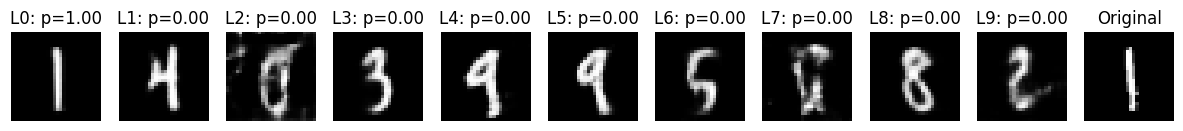

Class: 4


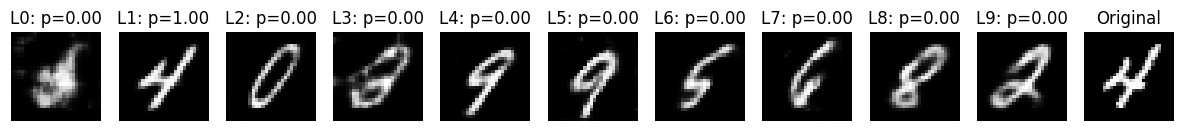

In [10]:
# Training Set
gen_train_eval_iter = iter(gen_train_eval)
inputs, labels = next(gen_train_eval_iter)


inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)
with torch.no_grad():
    reconstructions_gpu, node_leaves_gpu = model.compute_reconstruction(inputs_gpu)
reconstructions = move_to(reconstructions_gpu, 'cpu')
node_leaves = move_to(node_leaves_gpu, 'cpu')


for i in range(10):
    print("Class:", labels[i].item())
    fig, axs = plt.subplots(1, n_d+1, figsize=(15, 15))
    axs[n_d].imshow(display_image(inputs[i]), cmap=plt.get_cmap('gray'))
    axs[n_d].set_title("Original")
    axs[n_d].axis('off')
    for c in range(n_d):
        axs[c].imshow(display_image(reconstructions[c][i]), cmap=plt.get_cmap('gray'))
        axs[c].set_title(f"L{c}: " + f"p=%.2f" % torch.round(node_leaves[c]['prob'][i],decimals=2))
        axs[c].axis('off')

    plt.show()

Class: 7


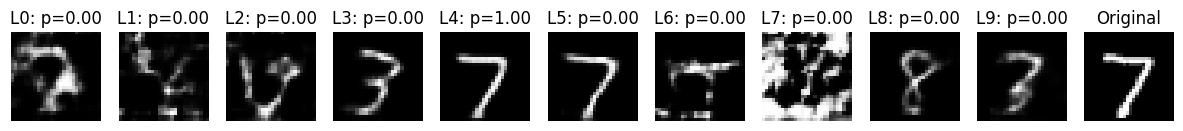

Class: 2


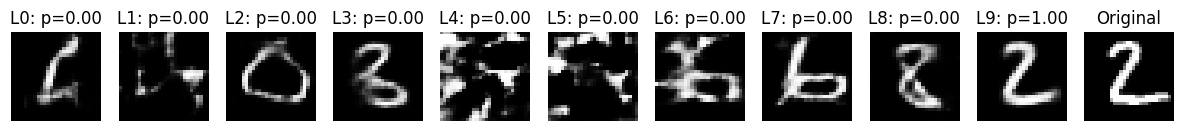

Class: 1


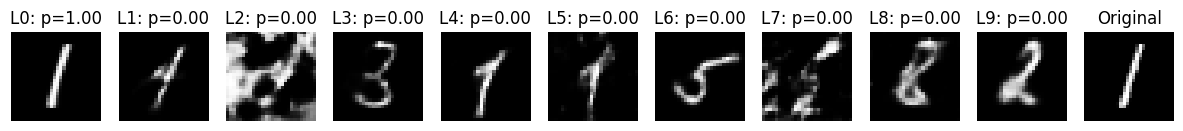

Class: 0


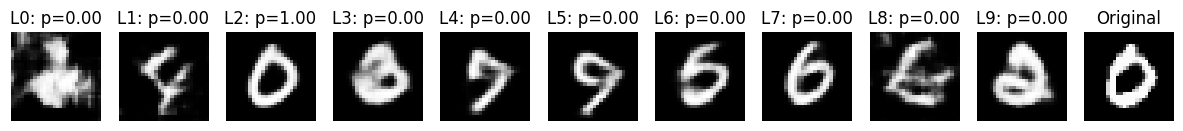

Class: 4


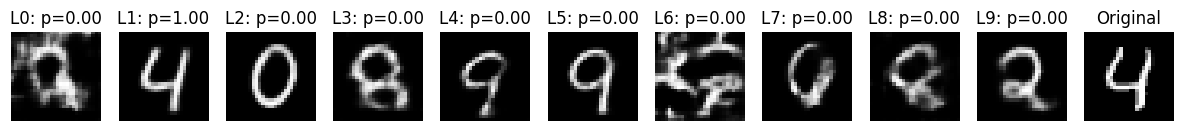

Class: 1


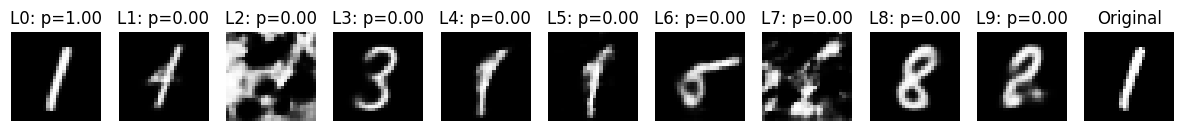

Class: 4


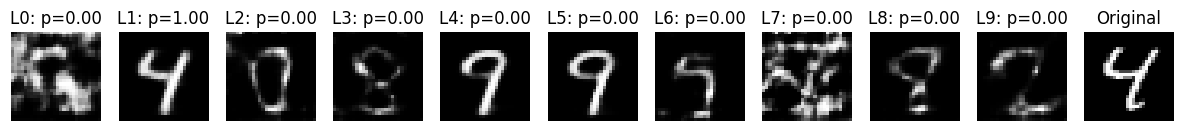

Class: 9


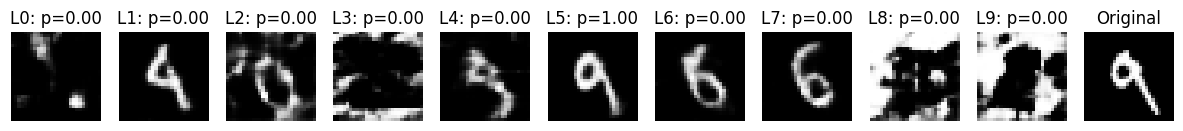

Class: 5


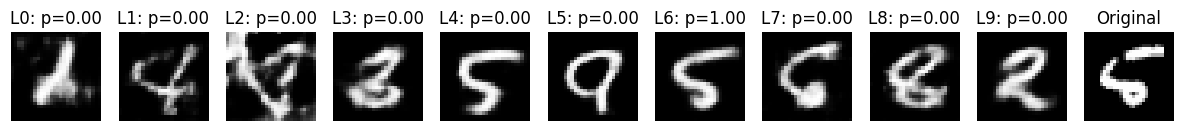

Class: 9


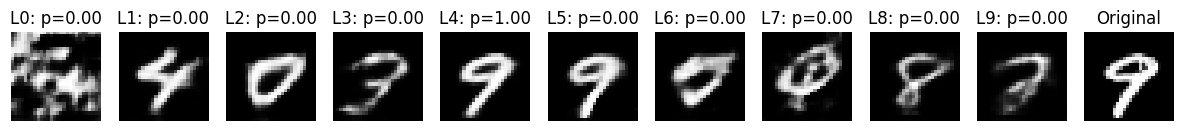

In [11]:
# Test Set
gen_test_iter = iter(gen_test)
inputs, labels = next(gen_test_iter)
inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)
with torch.no_grad():
    reconstructions_gpu, node_leaves_gpu = model.compute_reconstruction(inputs_gpu)
reconstructions = move_to(reconstructions_gpu, 'cpu')
node_leaves = move_to(node_leaves_gpu, 'cpu')


for i in range(10):
    print("Class:", labels[i].item())
    fig, axs = plt.subplots(1, n_d+1, figsize=(15, 15))
    axs[n_d].imshow(display_image(inputs[i]), cmap=plt.get_cmap('gray'))
    axs[n_d].set_title("Original")
    axs[n_d].axis('off')
    for c in range(n_d):
        axs[c].imshow(display_image(reconstructions[c][i]), cmap=plt.get_cmap('gray'))
        axs[c].set_title(f"L{c}: " + f"p=%.2f" % torch.round(node_leaves[c]['prob'][i],decimals=2))
        axs[c].axis('off')

    plt.show()

### Group reconstructions according to cluster assignment

In this subsection, given a leaf, we store the reconstructions of the first 100 samples, for which this leaf is their most likely cluster assignment. This allows us to visualize for each leaf, which samples fall into it, in order to gain insights on the cluster that each leaf learnt.

In [12]:
# Test Set
# Here, we store samples for each leaf simultaneously by iterating through the training set until
# every leaf has n_imgs associated samples, or we iterated through max_iter batches.
max_iter = 100
n_imgs = configs['training']['batch_size']

n_iter=0
gen_test_iter = iter(gen_test)
inputs, labels = next(gen_test_iter)
inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)
with torch.no_grad():
    reconstructions_gpu, node_leaves_gpu = model.compute_reconstruction(inputs_gpu)
reconstructions = move_to(reconstructions_gpu, 'cpu')
node_leaves = move_to(node_leaves_gpu, 'cpu')
p_c_z = torch.stack([node_leaves[i]['prob'] for i in range(len(node_leaves))],1)
clusterwise_reconst = [torch.zeros_like(reconstructions[0][0:2]) for i in range(len(reconstructions))]
while min([clusterwise_reconst[leaf_ind].shape[0] for leaf_ind in range(len(reconstructions))]) < n_imgs+2 and n_iter < max_iter:
    n_iter += 1
    if n_iter %10 == 0:
        print(n_iter)
    for i in range(n_imgs):
        leaf_ind = p_c_z[i].numpy().argmax()
        if clusterwise_reconst[leaf_ind].shape[0] < n_imgs+2:
            clusterwise_reconst[leaf_ind] = torch.vstack([clusterwise_reconst[leaf_ind], reconstructions[leaf_ind][i].unsqueeze(0)])
    inputs, labels = next(gen_test_iter)
    inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)
    with torch.no_grad():
        reconstructions_gpu, node_leaves_gpu = model.compute_reconstruction(inputs_gpu)
    reconstructions = move_to(reconstructions_gpu, 'cpu')
    node_leaves = move_to(node_leaves_gpu, 'cpu')
    p_c_z = torch.stack([node_leaves[i]['prob'] for i in range(len(node_leaves))],1)
for i in range(len(reconstructions)):
    clusterwise_reconst[i] = clusterwise_reconst[i][2:,:]

10


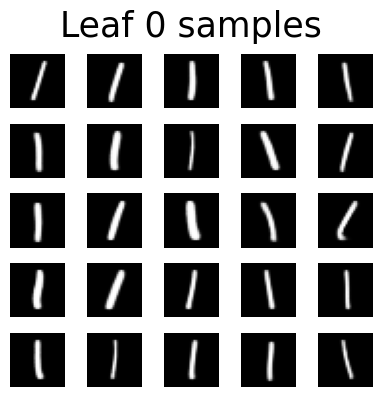

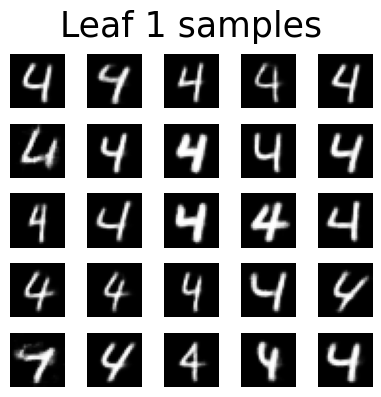

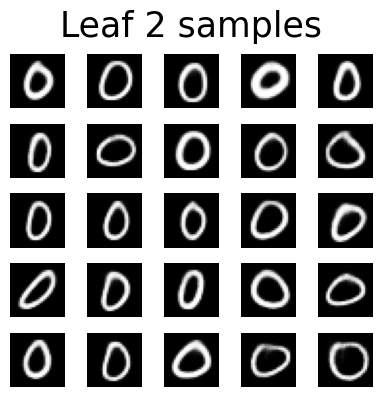

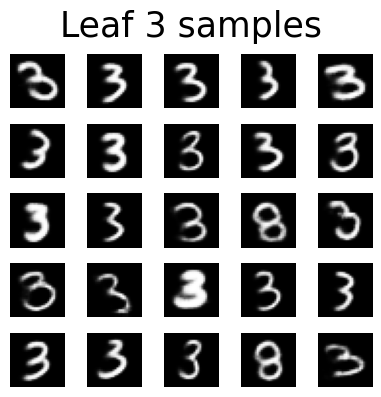

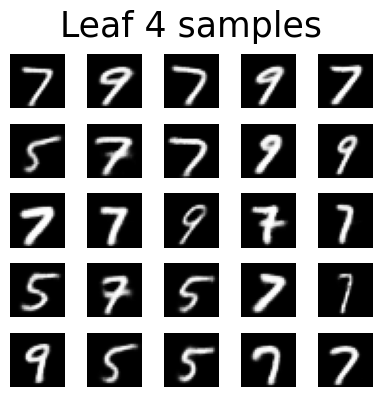

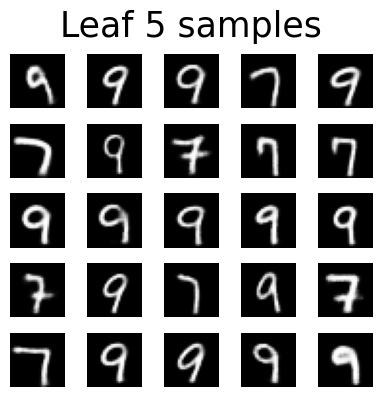

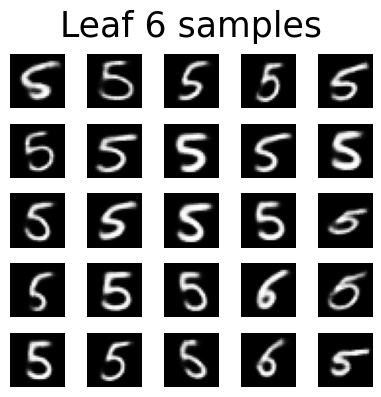

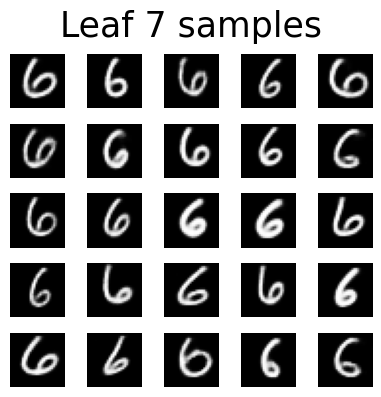

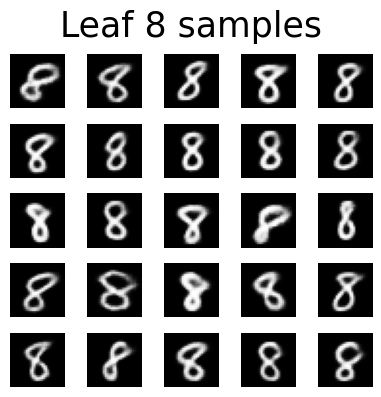

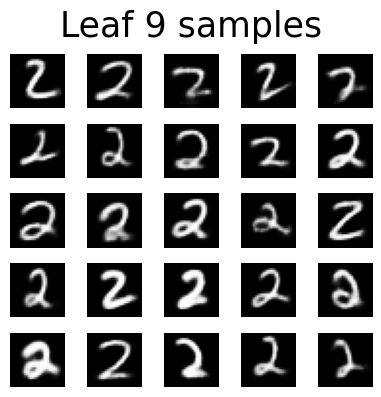

In [13]:
# For each leaf, we visualize n_grid x n_grid reconstructions of samples, 
# which have highest probability of being assigned to this cluster
n_leaves = len(clusterwise_reconst)
n_grid = min(5,int((clusterwise_reconst[leaf_ind].shape[0])**.5))

k=0
for l in range(n_leaves):
        fig, axs = plt.subplots(n_grid, n_grid, figsize=(4,4))
        i=0
        for a in range(n_grid):
            for b in range(n_grid):
                axs[a,b].set_axis_off()
                axs[a,b].imshow(display_image(clusterwise_reconst[k][i]), cmap=plt.get_cmap('gray'))
                i+=1
        fig.suptitle(f"Leaf {k} samples",fontsize=25)
        fig.tight_layout()
        fig.subplots_adjust(top=0.87)
        k+=1
plt.show()

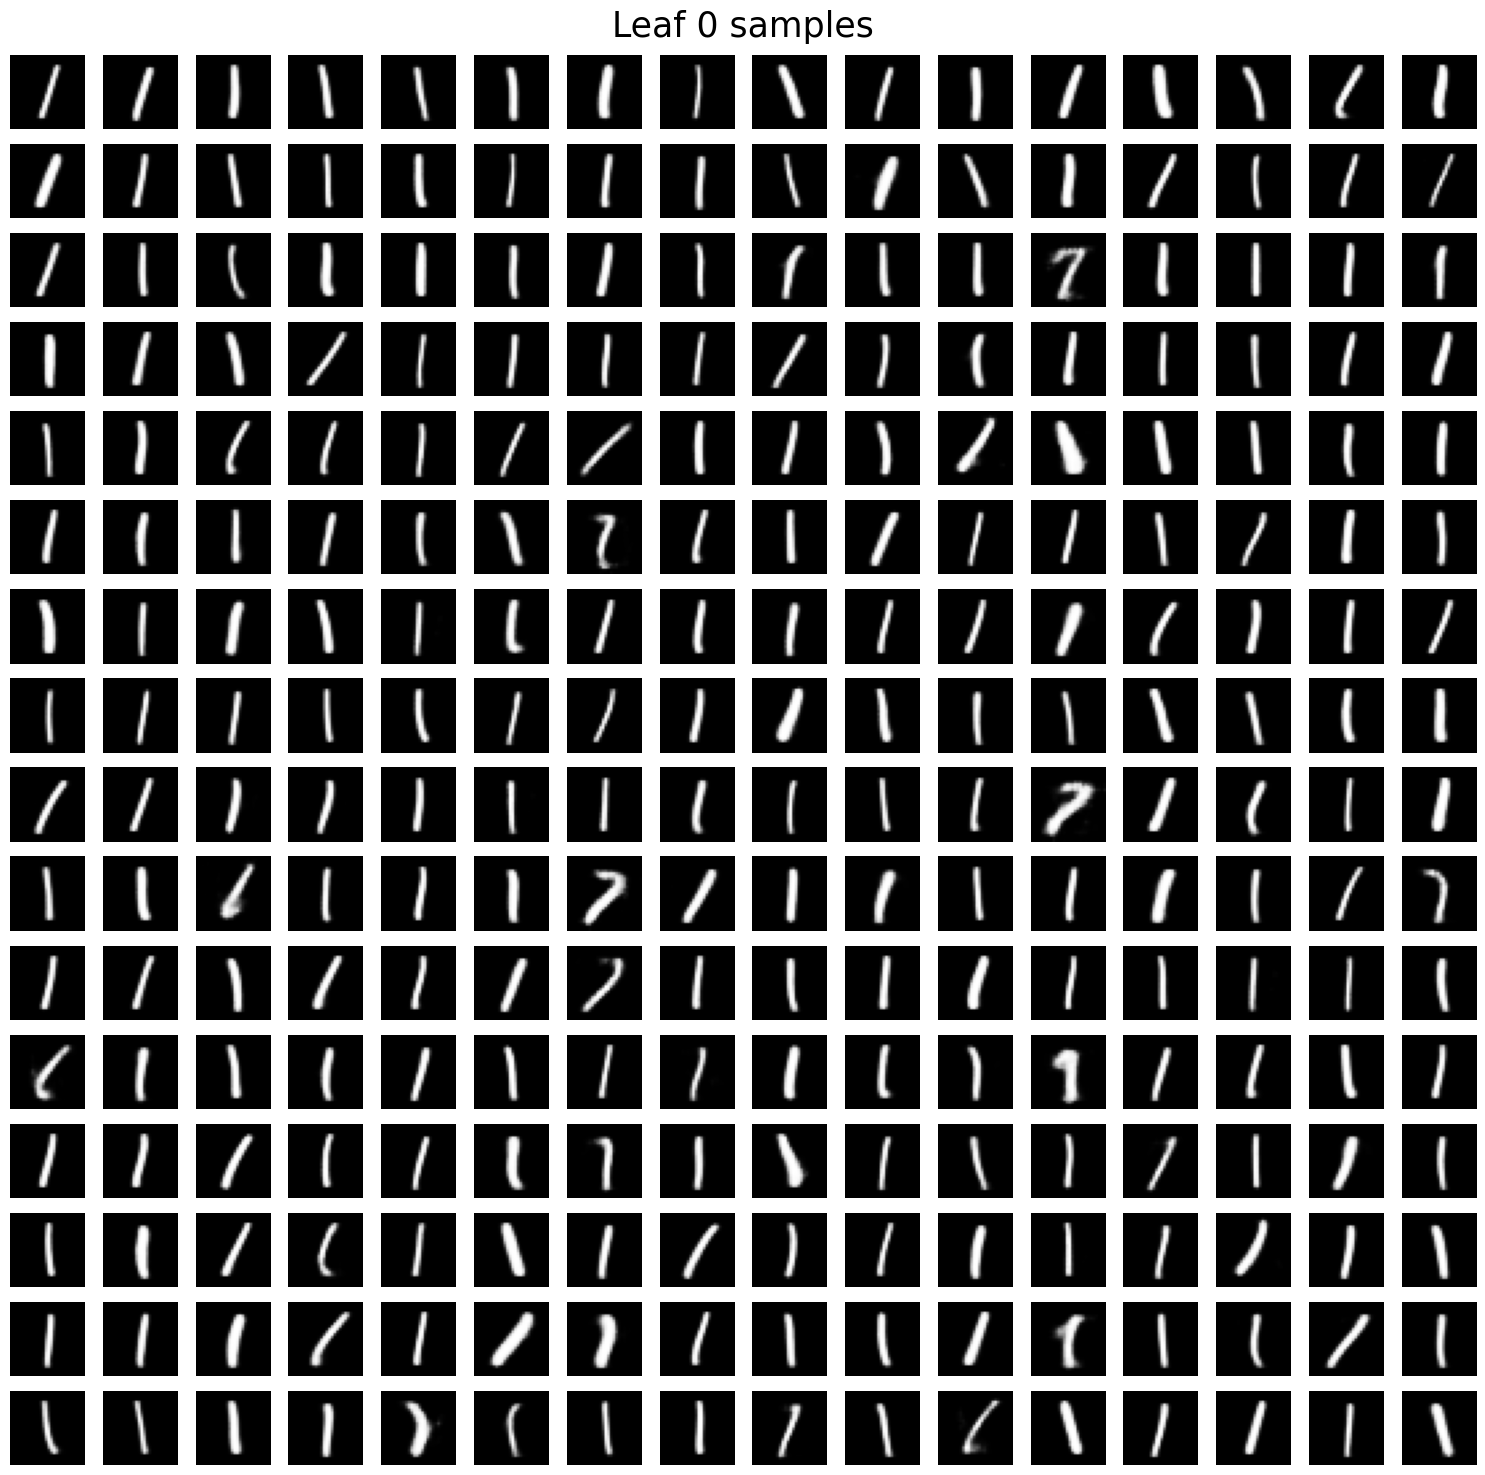

In [14]:
# For closer inspection, one can select a specific leaf by leaf_ind and investigate more reconstructions.
leaf_ind = 0
    
n_grid = int((clusterwise_reconst[leaf_ind].shape[0])**.5)
fig, axs = plt.subplots(n_grid, n_grid, figsize=(15,15))

i=0
for a in range(n_grid):
    for b in range(n_grid):
        axs[a,b].set_axis_off()
        axs[a,b].imshow(display_image(clusterwise_reconst[leaf_ind][i]), cmap=plt.get_cmap('gray'))
        i+=1
fig.suptitle(f"Leaf {leaf_ind} samples",fontsize=25)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## <a name="section_4"></a> 4. Tree and Representation Analysis 

In this section we explore the structure of the learnt tree as well as the representations

### Tree embeddings

Below, we visualize the learnt embeddings by performing PCA on each node. Set use_pca to False if you want to directly see the first two dimensions without dimensionality reduction.

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 76.99it/s]


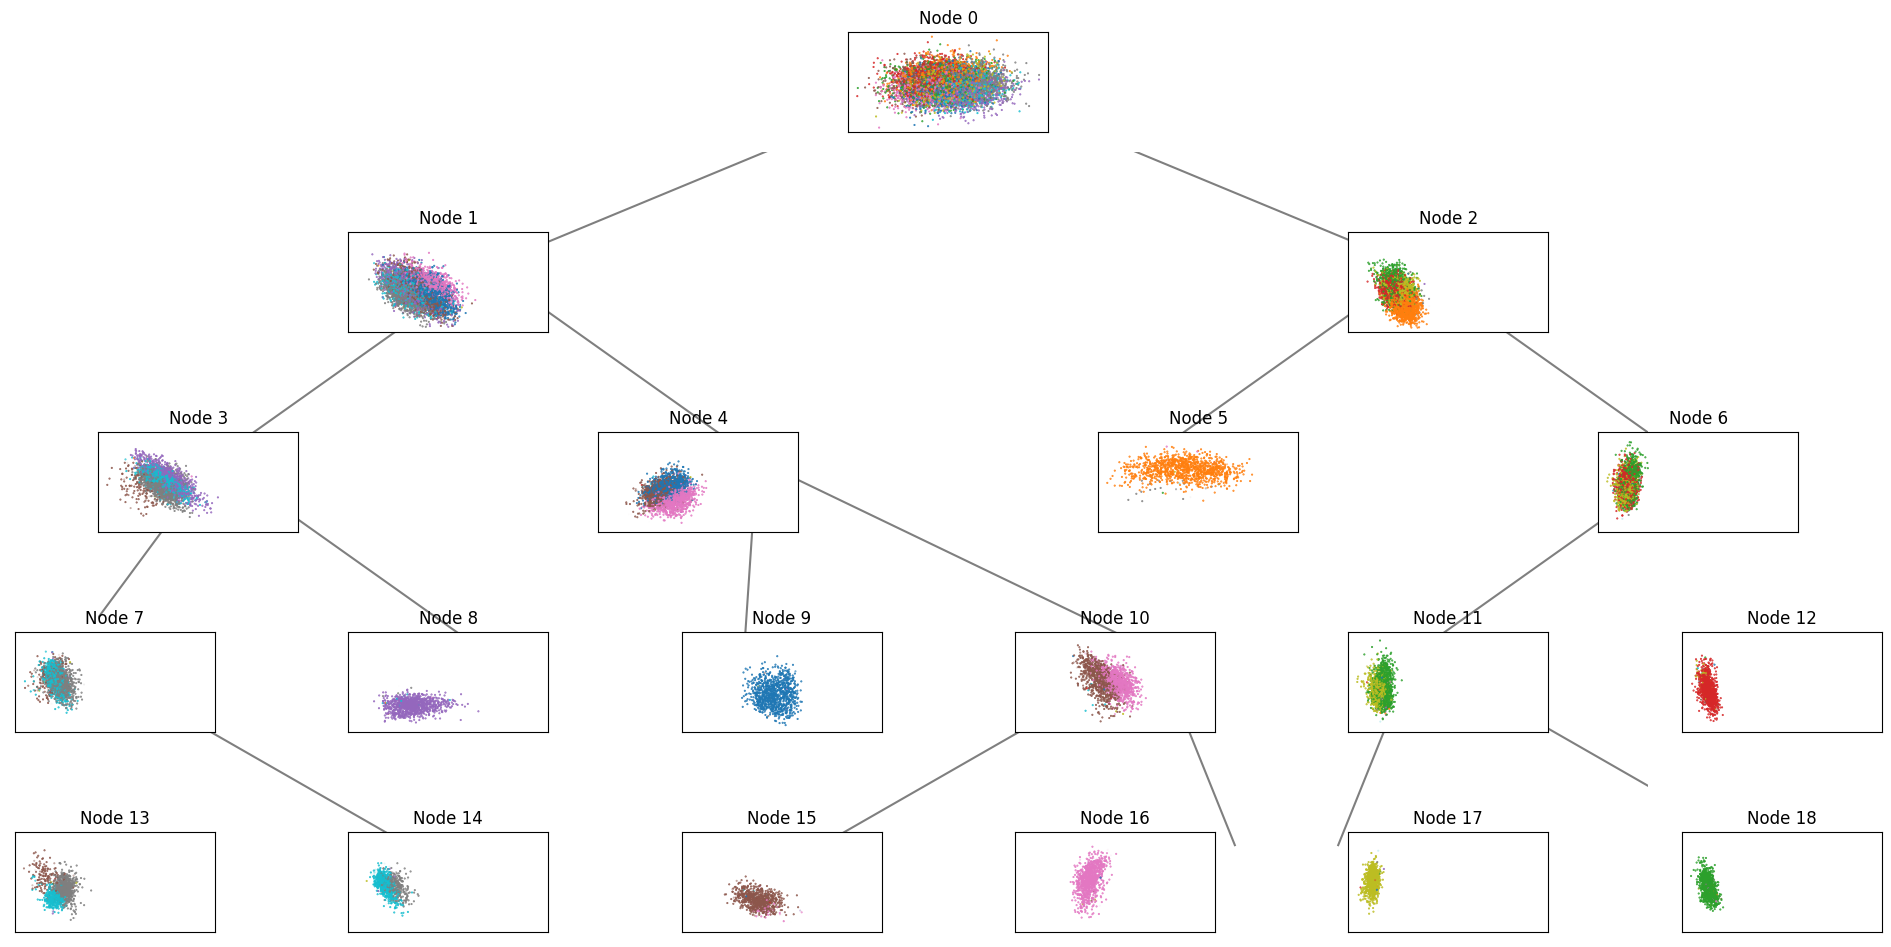

In [15]:
# Do you want to look at pca embeddings or learnt representations
use_pca = True

# pick data loader
data_loader = gen_test


# each entry in node_embeddings is a dictionary with keys 'prob' and 'z_sample' for each leaf
nb_nodes = len(data_tree)
node_embeddings = [{'prob': [], 'z_sample': []} for _ in range(nb_nodes)]
label_list = []

# iterate over test data points
for inputs, labels in tqdm(data_loader):
    inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)

    label_list.append(labels)

    with torch.no_grad():
        node_info = get_node_embeddings(model, inputs_gpu)
    node_info = move_to(node_info, 'cpu')

    # for each node, append the probability and z_sample to the list

    k = 0 # need this variable to skip "no digits" nodes
    for i in range(nb_nodes):
        j = i - k
        if data_tree[i][1] == 'no digits':
            k += 1
            continue

        node_embeddings[i]['prob'].append(node_info[j]['prob'].numpy())
        node_embeddings[i]['z_sample'].append(node_info[j]['z_sample'].numpy())

# flatten the lists
k = 0
for i in range(nb_nodes):
    if data_tree[i][1] == 'no digits':
        node_embeddings[i]['prob'] = []
        node_embeddings[i]['z_sample'] = []
        continue
    
    node_embeddings[i]['prob'] = np.concatenate(node_embeddings[i]['prob'])
    node_embeddings[i]['z_sample'] = np.concatenate(node_embeddings[i]['z_sample'])

label_list = np.concatenate(label_list)

# Draw the tree graph with scatter plots as nodes and arrows for edges
draw_tree_with_scatter_plots(data_tree, node_embeddings, label_list, pca = use_pca)

### Leaf embeddings

Below, we visualize the learnt leaf embeddings after performing PCA. This allows for a closer inspection of the leaf embeddings, which are also visualized in the tree above.

In [16]:
# get leaf embeddings for each test data point
gen_test_iter = iter(gen_test)
inputs, labels = next(gen_test_iter)
inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)
with torch.no_grad():
    reconstructions_gpu, node_leaves_gpu = model.compute_reconstruction(inputs_gpu)
reconstructions = move_to(reconstructions_gpu, 'cpu')
node_leaves = move_to(node_leaves_gpu, 'cpu')

# each entry in node_leaves is a dictionary with keys 'prob' and 'z_sample' for each leaf
node_leaves = [{'prob': [], 'z_sample': []} for _ in range(n_d)]
label_list = []

for inputs, labels in tqdm(gen_test):
    inputs_gpu, labels_gpu = inputs.to(device), labels.to(device)

    label_list.append(labels)

    with torch.no_grad():
        _, node_leaves_gpu = model.compute_reconstruction(inputs_gpu)
        node_leaves_cpu = move_to(node_leaves_gpu, 'cpu')
        
    # for each leaf, append the probability and z_sample to the list
    for i in range(n_d):
        node_leaves[i]['prob'].append(node_leaves_cpu[i]['prob'].numpy())
        node_leaves[i]['z_sample'].append(node_leaves_cpu[i]['z_sample'].numpy())

# flatten the lists
for i in range(n_d):
    node_leaves[i]['prob'] = np.concatenate(node_leaves[i]['prob'])
    node_leaves[i]['z_sample'] = np.concatenate(node_leaves[i]['z_sample'])

label_list = np.concatenate(label_list)

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 66.37it/s]


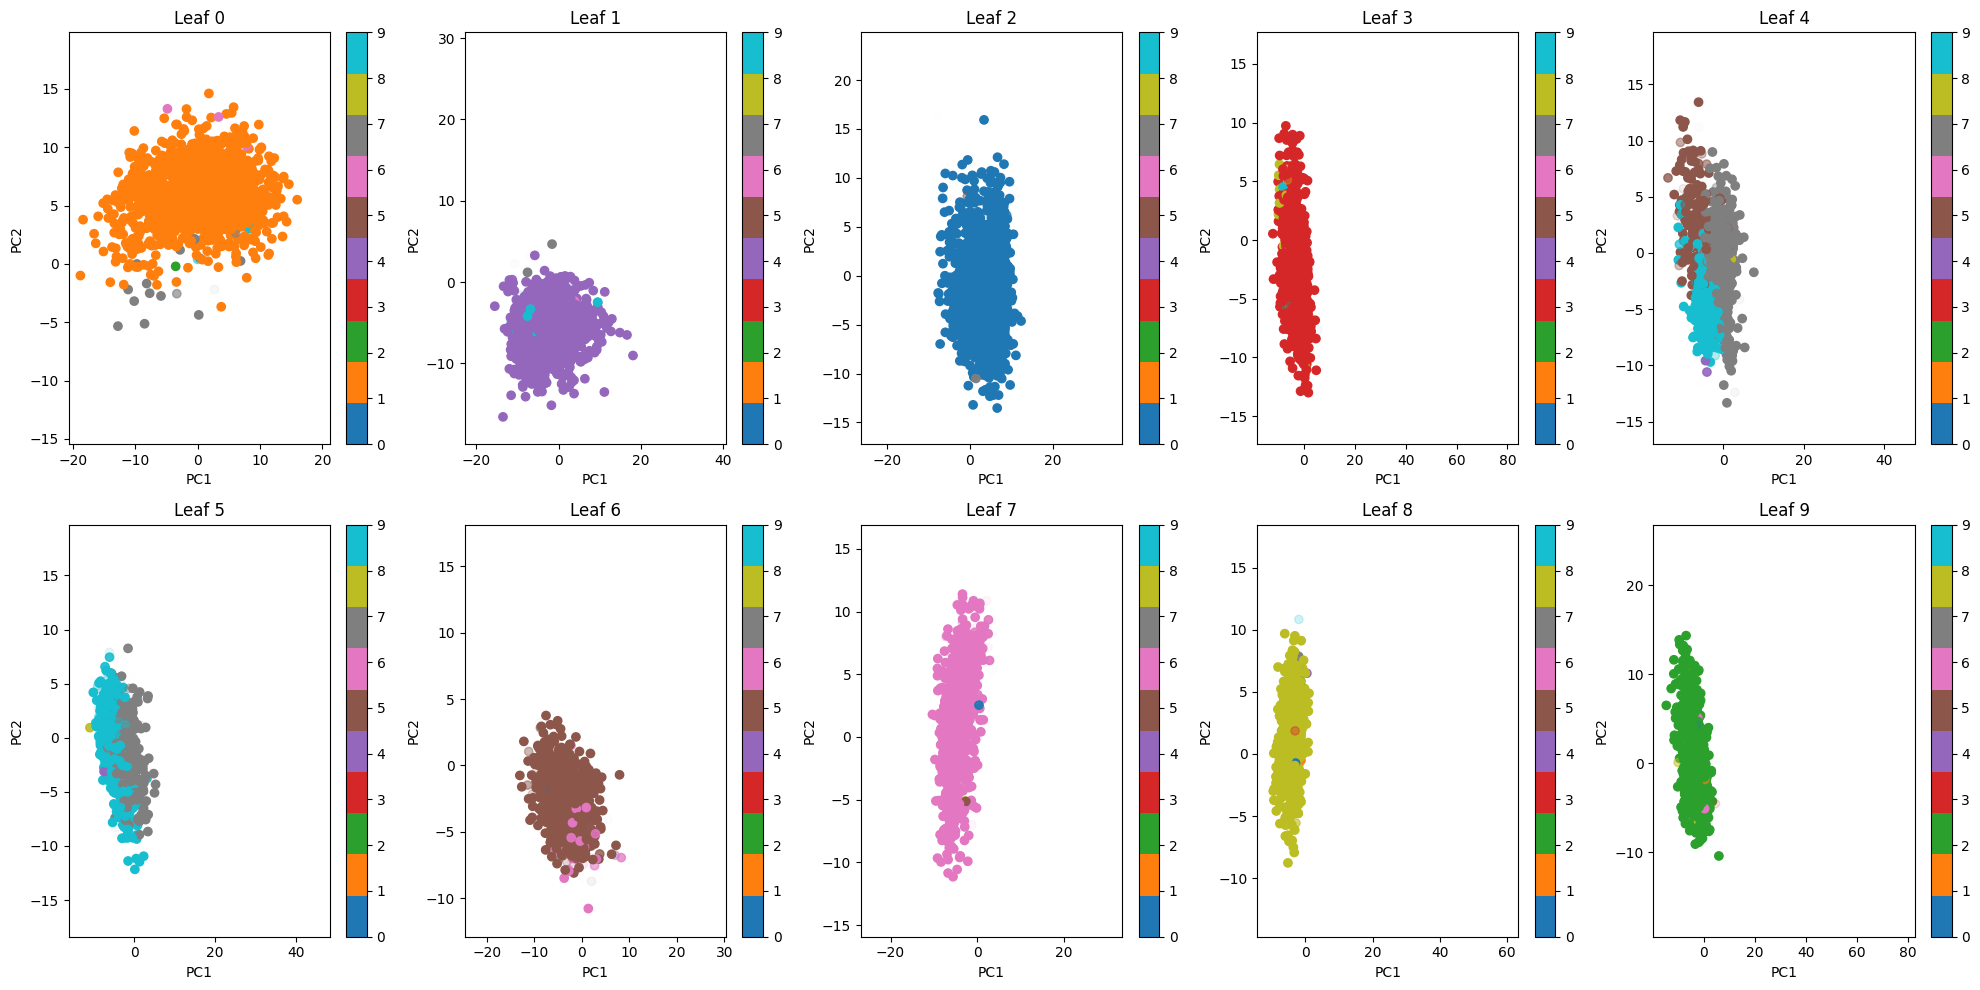

In [17]:
# visualize z_sample for each leaf, do PCA and plot in 2D
from sklearn.decomposition import PCA

# PCA on node_leaves['z_sample']
colors = label_list
plt.figure(figsize=(20, 10))

for i in range(n_d):
    z_sample = node_leaves[i]['z_sample']
    weights = node_leaves[i]['prob']

    pca = PCA(n_components=2)
    z_sample_pca = pca.fit_transform(z_sample)

    plt.subplot(2, -(-len(node_leaves)//2), i+1)
    plt.scatter(z_sample_pca[:, 0], z_sample_pca[:, 1], c=colors, cmap='tab10', alpha=weights)
    plt.title(f"Leaf {i}")
    plt.colorbar()
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.tight_layout()

## <a name="section_5"></a> 5. CelebA attributes

This section is designated for analyzing the learnt splits and clusters of datasets without ground truth cluster labels, but various attributes. It is designed with a focus on CelebA.

In [19]:
assert configs['data']['data_name'] == 'celeba'
import pandas as pd
data_dir = './data/celeba/'
attr = pd.read_csv(data_dir+'/list_attr_celeba.txt', sep="\s+", skiprows=1)
y_test = attr[182637:]
y_train = attr[:162770]

### Calculate cluster-matching attributes

Preprocessing step where we store for every node, the indeces of the test samples, whose most likely path went through said node

In [20]:
# Change to leafwise view of samples
prob_leaves = predict(gen_test, model, device,'prob_leaves')
y = np.squeeze(np.argmax(prob_leaves, axis=-1))
sample_ind = []
for i in range(len(np.unique(y))):
    sample_ind.append([])
for i in np.unique(y):
    sample_ind[i] = np.where(y==i)[0]
    
# Fill all internal nodes and create datatree with corresponding samples
data_tree_ids = []
for i in range(len(data_tree)):
    data_tree_ids.append([i,[]])
for listnode in reversed(data_tree_ids):
    i = listnode[0]
    if data_tree[i][3] == 1:
        # If leaf, just copy samples from above
        data_tree_ids[i][1] = sample_ind[i-(len(data_tree_ids)-len(sample_ind))]
    else:
        # If internal node, take samples from children
        children = []
        for j in range(len(data_tree)):
            if data_tree[j][2] == i:
                children.append(j)
        assert len(children)==2
        data_tree_ids[i][1] = np.sort(np.concatenate((data_tree_ids[children[0]][1],data_tree_ids[children[1]][1])))
        
        
        
# Final ID-tree, where for each node, we store which test sample went through it
data_tree_ids

  0%|                                                    | 0/78 [00:00<?, ?it/s]/home/mvandenhi/anaconda3/envs/treevae/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|███████████████████████████████████████████| 78/78 [00:38<00:00,  2.05it/s]


[[0, array([    0,     1,     2, ..., 19959, 19960, 19961])],
 [1, array([    0,     2,     3, ..., 19958, 19960, 19961])],
 [2, array([    1,     5,     9, ..., 19952, 19953, 19959])],
 [3, array([    2,     3,     4, ..., 19941, 19949, 19960])],
 [4, array([    0,     8,    17, ..., 19957, 19958, 19961])],
 [5, array([    5,    11,    20, ..., 19951, 19953, 19959])],
 [6, array([    1,     9,    10, ..., 19932, 19947, 19952])],
 [7, array([    7,    12,    13, ..., 19924, 19934, 19949])],
 [8, array([    2,     3,     4, ..., 19940, 19941, 19960])],
 [9, array([   19,    30,    45, ..., 19957, 19958, 19961])],
 [10, array([    0,     8,    17, ..., 19944, 19955, 19956])],
 [11, array([    5,    11,    43, ..., 19950, 19953, 19959])],
 [12, array([   20,    27,    33, ..., 19929, 19943, 19951])],
 [13, array([    9,    15,    16, ..., 19917, 19927, 19932])],
 [14, array([    1,    10,    14, ..., 19916, 19947, 19952])]]

For each split, we additionally store the five attribute that correlate most highly with the the split. This gives an intuition on what attributes the split is based on, i.e. which characteristics the split differentiates between.

Note that for CelebA, the "ground truth" attributes are in our opinion not the most descriptive ones regarding overall image&cluster impression and focus sometimes on details, on which we don't pick up on.

In [21]:
# Highest correlated features per split
data_tree_new = data_tree.copy()
for i in range(len(data_tree_ids)):
    in_leaf = False
    node_ind = data_tree_ids[i][1]
    # Samples in node before split
    node_samples = y_test.iloc[node_ind]
    # Split of samples
    node_split = np.zeros(len(y_test))
    children = []
    for j in range(len(data_tree)):
        if data_tree[j][2] == i:
            children.append(j)
        if children == []:
            in_leaf = True
        else:
            in_leaf = False
    if not in_leaf: 
        child_left = children[0]
        node_split[data_tree_ids[child_left][1]] = 1
        node_split = node_split[node_ind]
        # Store corr coefficients
        corr = np.corrcoef(np.concatenate((np.array(node_samples),np.expand_dims(node_split,1)),1).T)[len(y_test.columns),0:len(y_test.columns)]
        data_tree_ids[i].append(corr)
        
        # Store 5 strongest correlations
        ind = np.abs(corr).argsort()[-5:][::-1]
        features = y_test.columns[ind].tolist()
        for k in range(len(ind)):
            if corr[ind[k]] < 0:
                features[k] = 'not ' + features[k]
            features[k] = features[k] + ' ({})'.format(round(corr[ind[k]], 2))
        data_tree_ids[i].append(features)
        
data_tree_ids

[[0,
  array([    0,     1,     2, ..., 19959, 19960, 19961]),
  array([-0.19672442,  0.31651575,  0.34713518, -0.20092082, -0.11376557,
          0.17828015,  0.12514536, -0.16309559, -0.01590548,  0.09303592,
         -0.06902774,  0.1523074 , -0.07166325, -0.12110693, -0.08076038,
         -0.21578334, -0.16424208, -0.10494745,  0.50424584,  0.23564559,
         -0.49673638,  0.07323019, -0.16661819, -0.02146123,  0.28464794,
          0.12773177,  0.06591808,  0.2047743 , -0.10081349,  0.22319561,
         -0.15226273,  0.19624476, -0.07312307,  0.34728563,  0.18696898,
         -0.12941875,  0.56114809,  0.201324  , -0.17099047,  0.15731413]),
  ['Wearing_Lipstick (0.56)',
   'Heavy_Makeup (0.5)',
   'not Male (-0.5)',
   'Wavy_Hair (0.35)',
   'Attractive (0.35)']],
 [1,
  array([    0,     2,     3, ..., 19958, 19960, 19961]),
  array([ 0.14625648,  0.01246908,  0.00856015,  0.0668704 ,  0.06730187,
         -0.52043703, -0.03593812,  0.09678273,  0.25789335, -0.40081021,
      

As a summary, for each attribute, we print the split that has the highest correlation with it. This gives an intuition on what internal node differentiates the most according to a given attribute.

In [22]:
# Attributewise node with highest correlation (i.e. internal node that was splitting attribute the most)
attr_maxnode = y_test.columns.tolist()
for i in range(len(y_test.columns)):
    attrcorr = []
    for node in range(len(data_tree_ids)):
        if len(data_tree_ids[node])==len(data_tree_ids[0]):
            attrcorr.append(data_tree_ids[node][2][i])
    attrcorr = np.array(attrcorr)
    if len(np.argwhere(np.isnan(attrcorr)).squeeze(1))>0:
        attrcorr[np.argwhere(np.isnan(attrcorr)).squeeze(1)] = 0
    ind = np.argmax(np.abs(attrcorr))
    attr_maxnode[i] = attr_maxnode[i] + ": " + f'{ind}' ' ({})'.format(round(attrcorr[ind], 2))
attr_maxnode

['5_o_Clock_Shadow: 3 (-0.27)',
 'Arched_Eyebrows: 0 (0.32)',
 'Attractive: 0 (0.35)',
 'Bags_Under_Eyes: 0 (-0.2)',
 'Bald: 0 (-0.11)',
 'Bangs: 1 (-0.52)',
 'Big_Lips: 0 (0.13)',
 'Big_Nose: 3 (-0.21)',
 'Black_Hair: 4 (-0.36)',
 'Blond_Hair: 4 (0.69)',
 'Blurry: 2 (-0.1)',
 'Brown_Hair: 4 (-0.25)',
 'Bushy_Eyebrows: 2 (0.24)',
 'Chubby: 3 (-0.15)',
 'Double_Chin: 3 (-0.19)',
 'Eyeglasses: 0 (-0.22)',
 'Goatee: 0 (-0.16)',
 'Gray_Hair: 6 (0.18)',
 'Heavy_Makeup: 0 (0.5)',
 'High_Cheekbones: 0 (0.24)',
 'Male: 3 (-0.5)',
 'Mouth_Slightly_Open: 5 (0.11)',
 'Mustache: 0 (-0.17)',
 'Narrow_Eyes: 2 (-0.04)',
 'No_Beard: 0 (0.28)',
 'Oval_Face: 2 (0.13)',
 'Pale_Skin: 0 (0.07)',
 'Pointy_Nose: 0 (0.2)',
 'Receding_Hairline: 3 (-0.22)',
 'Rosy_Cheeks: 0 (0.22)',
 'Sideburns: 3 (-0.16)',
 'Smiling: 0 (0.2)',
 'Straight_Hair: 2 (0.11)',
 'Wavy_Hair: 0 (0.35)',
 'Wearing_Earrings: 0 (0.19)',
 'Wearing_Hat: 4 (-0.14)',
 'Wearing_Lipstick: 0 (0.56)',
 'Wearing_Necklace: 0 (0.2)',
 'Wearing_Neckt

### Evaluation of clusters

We can analyze the clustering quality according to certain attributes. To do this, in the second cell, pick the indeces of the attributes, whose intersections you want to determine as ground truth clusterings. Then, the NMI is calculated for treating the selected attributes' intersections as ground-truth clusters.

In [23]:
y_test.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [24]:
# Pick labels here
label_ind = [2,20,39]
print([attr_maxnode[i] for i in label_ind])

['Attractive: 0 (0.35)', 'Male: 3 (-0.5)', 'Young: 3 (0.27)']


In [25]:
if len(label_ind)==2:
    label_dict = {
        (-1, -1): 0,
        (-1, 1): 1,
        (1, -1): 2,
        (1, 1): 3
    }
else:
    label_dict = {
        (-1, -1, -1): 0,
        (-1, -1, 1): 1,
        (-1, 1, -1): 2,
        (-1, 1, 1): 3,
        (1, -1, -1): 4,
        (1, -1, 1): 5,
        (1, 1, -1): 6,
        (1, 1, 1): 7
    }
selected_classes = np.array(y_test.iloc[:, label_ind])
selected_classes = [tuple([x for x in a]) for a in selected_classes]
label_true = [label_dict[sample_labels] for sample_labels in selected_classes]

In [26]:
print('NMI:')
normalized_mutual_info_score(y, label_true)

NMI:


0.12866313834345094

### Create attribute-wise percentage table for leaves

This subsection presents the frequency of the attributes for each leaf. The numbers indicate the percentage of samples assigned to a given leaf, that contain a certain attribute. For example: 67% of all people assigned to leaf 3 are blonde.

In [27]:
leaf_attr = []
n_leaves = len(np.unique(y))
for i in range(1,1+n_leaves):
    data_tree_ids[-i].append((y_test.iloc[data_tree_ids[-i][1]] == 1).mean())
    leaf_attr.append((y_test.iloc[data_tree_ids[-i][1]] == 1).mean())

In [28]:
leaf_attr_table = pd.DataFrame(np.stack(leaf_attr)[::-1])
leaf_attr_table.columns = y_test.columns

pd.set_option('display.max_columns', None)
leaf_attr_table.round(3)*100

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.6,48.8,78.7,10.3,0.0,1.6,39.1,10.3,38.1,1.1,2.8,26.9,13.5,1.3,0.7,0.9,0.3,0.0,75.7,59.7,2.8,49.0,0.1,13.3,99.0,37.9,6.2,39.5,3.6,9.3,0.2,54.3,18.3,60.7,27.5,0.2,91.5,19.1,0.2,93.7
1,14.7,35.4,52.4,19.7,2.2,1.2,33.8,26.9,36.3,3.7,4.2,18.0,17.7,7.5,8.4,2.5,4.2,3.8,43.4,57.0,45.0,58.0,2.6,13.0,83.6,34.8,3.6,37.5,16.5,12.9,5.3,66.6,19.2,36.2,26.3,0.7,52.2,13.3,9.8,74.4
2,0.3,52.6,70.6,9.1,0.1,24.1,44.4,8.1,0.9,66.7,4.7,12.7,1.8,0.6,1.5,0.5,0.1,2.2,76.6,69.1,2.3,58.3,0.0,15.3,99.6,34.4,5.8,44.6,3.0,21.2,0.2,66.4,18.0,57.5,33.1,0.6,91.5,29.6,0.4,78.6
3,2.1,31.4,61.0,11.4,0.0,61.7,36.4,14.1,26.0,2.2,3.1,34.3,8.3,1.6,1.5,2.0,0.9,0.1,59.7,52.4,13.4,47.6,0.7,15.4,97.1,32.6,6.2,28.3,0.2,8.5,0.9,51.2,17.2,53.7,24.9,5.6,79.1,20.6,1.2,79.8
4,26.2,16.9,38.4,33.9,4.0,3.4,27.9,35.5,36.4,5.8,3.0,12.1,24.1,10.8,9.8,8.0,10.9,3.9,15.0,44.7,76.9,50.6,10.1,13.8,67.7,31.8,1.7,21.8,16.0,2.4,8.5,54.7,31.4,10.9,12.8,4.0,18.4,5.0,18.1,69.9
5,21.6,13.1,39.5,33.6,1.5,11.1,25.4,29.3,40.2,2.6,5.4,15.5,23.4,6.6,4.8,5.5,9.1,1.2,12.4,38.3,69.3,39.9,8.2,14.5,69.3,25.4,3.2,17.5,5.9,0.5,11.1,42.4,26.1,23.1,12.1,5.4,21.2,5.2,10.1,75.5
6,7.5,12.4,22.4,28.2,6.9,9.1,26.7,28.3,7.8,26.1,8.4,4.8,6.2,9.5,6.4,19.2,6.9,13.1,16.3,36.7,53.4,50.7,5.2,16.3,81.6,20.8,3.6,16.8,16.1,0.8,6.3,37.3,20.2,15.9,13.8,12.0,24.9,9.8,10.3,61.8
7,8.1,10.1,22.3,19.2,3.4,11.4,25.7,19.6,24.6,7.1,10.3,13.7,6.7,5.9,4.3,17.0,5.7,3.4,12.8,22.1,56.3,41.6,5.3,18.4,81.3,14.5,2.9,18.5,8.3,0.3,6.1,22.4,18.1,24.5,11.7,7.2,25.1,6.0,7.7,65.9


Here, one can create new attributes by combining previous attributes

In [29]:
new_vars =[]
for i in range(1,1+n_leaves):
    temp = y_test.iloc[data_tree_ids[-i][1]] == 1
    temp['Hair_Loss'] = np.clip(temp['Bald'] + temp['Receding_Hairline'],0,1)
    temp['Dark_Hair'] = np.clip(temp['Brown_Hair'] + temp['Black_Hair'],0,1)
    temp['Happy'] = np.clip(temp['Smiling'] + temp['Mouth_Slightly_Open'],0,1)
    temp['Light_Hair'] = np.clip(temp['Blond_Hair'] + temp['Gray_Hair'],0,1)
    temp['Beard'] = np.clip(temp['5_o_Clock_Shadow'] + 1-temp['No_Beard'],0,1)

    new_vars.append([temp['Hair_Loss'].mean(),temp['Dark_Hair'].mean(),temp['Happy'].mean(),temp['Light_Hair'].mean(),temp['Beard'].mean()])
    
new_vars_table = pd.DataFrame(np.stack(new_vars)[::-1])
new_vars_table.columns = ['Hair_Loss','Dark_Hair','Happy','Light_Hair','Beard']
new_vars_table.round(3)*100

,Hair_Loss,Dark_Hair,Happy,Light_Hair,Beard
0,3.6,64.3,63.4,1.2,1.1
1,17.8,53.8,72.1,7.4,20.6
2,3.0,13.6,74.4,68.5,0.4
3,0.2,59.7,61.6,2.3,3.7
4,18.9,48.4,61.5,9.6,39.5
5,6.9,55.3,51.5,3.8,36.5
6,21.2,12.5,57.5,38.6,21.3
7,10.6,38.0,46.2,10.3,21.4
